# Imports

In [2]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from pymystem3 import Mystem
import plotly.express as px
from time import time
from IPython.display import clear_output
from sys import getsizeof
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile,chi2


import warnings
warnings.filterwarnings('ignore')

# General

In [3]:
UKR_CHANNELS = [
    'Труха⚡️Украина', 'Лачен пишет', 'Украинская правда. Главное',
    'Вы хотите как на Украине?', 'Борис Філатов', 'RAGNAROCK PRIVET',
    'УНИАН - новости Украины | война с Россией | новини України | війна з Росією',
    'Украина 24/7 Новости | Война | Новини', 'Быть Или',
    'Украина Сейчас: новости, война, Россия'
]

UKR_LETTERS = ['ї', 'є', 'ґ', 'і']

CHEAT_WORDS = [
    '03', '04', '05', '1378', '2022', '3801', '3806', '4149', '4276',
    '4279', '9521', '9842', 'akimapachev', 'amp', 'anna', 'com',
    'daily', 'diza', 'donbass', 'epoddubny', 'https', 'index', 'me',
    'news', 'opersvodki', 'pravda', 'rus', 'rvvoenkor', 'sashakots',
    'ua', 'wargonzo', 'www', 'www pravda', 'мид', 'труха', 'труха украина',
    'украина сейчас', 'pravda com', 'daily news', 'com ua', 'https www',
    'me rvvoenkor', 'rus news', 'ua rus', 'wargonzo наш'
]

In [4]:
def time_decorator(function):
    from time import time
    def inner(*args, **kwargs):
        start = time()
        result = function(*args, **kwargs)
        elapsed_time = round(time() - start, 2)
        output = f'{function.__name__} took {elapsed_time} seconds.'
        print(output)
        return result
    return inner

# Data Reading

In [5]:
@time_decorator
def read_data(filename='random_msgs.csv', sep='¶∆',
                  header=None):
        """
        Reads the csv file into 4 columns:
        channel
        date of publication
        message
        ukrainian - 1 if ukrainian channel, 0 - otherwise.
        """
        data = pd.read_csv(filename, sep=sep, header=header)
        data.columns = ['channel', 'date', 'msg']
        data['ukrainian'] = data['channel'].\
            apply(lambda x: 1 if x in UKR_CHANNELS else 0)
        data['ukrainian'] = data['ukrainian'].astype('int8')
        data = data[data['channel'] != 'вечеряємо']
        return data

In [ ]:
data = read_data()
data.sample(5)

read_data took 3.01 seconds.


,channel,date,msg,ukrainian
51682,"Украина Сейчас: новости, война, Россия",2022-05-01 13:08:01+00:00,Российские войска снова обстреляли одно из сел...,1
110520,СОЛОВЬЁВ,2022-05-11 14:02:46+00:00,Президент России назначил исполняющих обязанно...,0
93671,РИА Новости,2022-03-31 17:53:54+00:00,Аукционный дом Christie's запретил продажу пре...,0
56602,RAGNAROCK PRIVET,2022-05-13 13:30:37+00:00,"Друзья, война не окончена! Все мы понимаем,что...",1
71405,Украина 24/7 Новости | Война | Новини,2022-03-01 17:53:07+00:00,❗️Мощный взрыв в Чугуеве рядом с аэропортом.,1


In [ ]:
percent_ukr = data['ukrainian'].mean()
percent_rus = 1 - percent_ukr
print("Ukrainian media data percentage:",percent_ukr)
print("Russian media data percentage:",percent_rus)

Ukrainian media data percentage: 0.4295310285326924
Russian media data percentage: 0.5704689714673076


# Preprocessing (removal of Ukrainian language posts, removal of short posts)

In [6]:
@time_decorator
def preprocess(data, remove_ukr_msgs=True, cut_less_than=18):
        """
        This method:
        removes short messages (with less than 18 characters);
        removes messages with ukrainian letters.
        """
        if remove_ukr_msgs:
            for letter in UKR_LETTERS:
                data = data[data['msg'].str.lower().\
                                        str.contains(letter) == False]
        data = data[data['msg'].str.len() > cut_less_than]
        data = data.reset_index(drop=True)
        return data

In [ ]:
data = preprocess(data)
data.shape

preprocess took 0.59 seconds.


(29614, 4)

In [ ]:
percent_ukr = data['ukrainian'].mean()
percent_rus = 1 - percent_ukr
print("Ukrainian media data percentage:",percent_ukr)
print("Russian media data percentage:",percent_rus)

Ukrainian media data percentage: 0.4014515533214061
Russian media data percentage: 0.598548446678594


# Lemmatizing

In [7]:
@time_decorator
def lemmatize(data,*sentences):
        """
        This method has 2 usages:
        internal; i.e. to lemmatize all messages in the dataset. Runs about 2.5
        minutes.
        outside; to lemmatize a given sequence of sentences.
        """
        mystem = Mystem()
        if not sentences:
          def preprocess_text(text):
                      tokens = mystem.lemmatize(text.lower())
                      text = " ".join(tokens)
                      return text

          data['msg'] = data['msg'].apply(preprocess_text)
          return data
        else:
            result = []
            for sentence in sentences:
                tokens = mystem.lemmatize(sentence.lower())
                result.append(' '.join(tokens))
            return result


In [ ]:
data = lemmatize(data)

# Train, test split

In [8]:
def train_test_split2(data, random_state=1, train_size=.8):
        """
        This method clones scikit-learn train_test_split.
        """
        train,test = train_test_split(data, random_state=random_state, train_size=train_size
        )
        X_train,ukr_train,channel_train = train['msg'], train['ukrainian'],train['channel']
        X_test, ukr_test, channel_test = test['msg'], test['ukrainian'],test['channel']
        return X_train,ukr_train,channel_train,X_test, ukr_test, channel_test

In [ ]:
X_train,ukr_train,channel_train,X_test, ukr_test, channel_test = train_test_split2(data)

In [ ]:
X_train.shape, X_test.shape, ukr_train.shape, ukr_test.shape, channel_train.shape, channel_test.shape

((110447,), (27612,), (110447,), (27612,), (110447,), (27612,))

# Vectorization

In [9]:
@time_decorator
def vectorize(X_train, ngram_range=(1,1), sublinear_tf=True, binary=False):
        """
        This method creates a pipeline of CountVectorizer() and TfidfTransformer().
        If CountVectorizer is needed - use count_transform method.
        If TfidfVectorizer is needed - just call a tfidf_transform method.
        """
        tfidf = Pipeline([
                    ('vect', CountVectorizer(binary=binary, ngram_range=ngram_range)),
                    ('tfidf', TfidfTransformer(sublinear_tf=sublinear_tf))
                ]).fit(X_train)
        vect = tfidf['vect']
        return tfidf,vect

In [ ]:
tfidf,vect = vectorize(X_train,ngram_range=(1,2), sublinear_tf=True,binary=True )

vectorize took 19.32 seconds.


# Transform

In [10]:
@time_decorator
def tfidf_transform(tfidf,X_train,X_test):
        """
        Applies TfidfTransform to data.
        """
        X_train = tfidf.transform(X_train).T
        X_test= tfidf.transform(X_test).T
        return X_train, X_test


In [ ]:
X_train, X_test = tfidf_transform(tfidf,X_train,X_test)
X_train.shape, X_test.shape

In [17]:
@time_decorator
def count_transform(vect,X_train,X_test):
        """
        Applies CountTransform to data.
        """
        X_train = vect.transform(X_train).asfptype().T
        X_test = vect.transform(X_test).asfptype().T
        return X_train, X_test


# Remove cheat words

or preprocessor.count_transform() if CountVectorizer model is needed.

In [11]:
@time_decorator
def remove_cheat_words(X_train,X_test,channel_train,vectorizer, method='manual', freq_pivot=.5,
                           cheat_words=CHEAT_WORDS):
        """
        Removes cheat_words, like channel tags, social media links or
        authors names.
        """
        if method == 'manual':
            delete_mask = np.zeros(X_train.shape[0], dtype=bool)
            delete_mask[np.isin(np.array(
                    vectorizer.get_feature_names_out()), cheat_words)
            ] = True
            X_train = X_train.T[:, ~delete_mask].T
            X_test = X_test.T[:, ~delete_mask].T
            cheat_words = np.array(vectorizer.get_feature_names_out() ).T[delete_mask]
            
        else:
            delete_mask = np.zeros(X_train.shape[0], dtype=bool)
            for channel in channel_train.unique():
                arr = X_train.T[channel_train == channel]
                delete_mask |= np.array((np.sum(arr > 0, axis=0) / arr.shape[0]) > .5)[0]

            X_train = X_train.T[:, ~delete_mask].T
            X_test = X_test.T[:, ~delete_mask].T
            delete_mask = delete_mask
            cheat_words = np.array(
                vectorizer.get_feature_names_out()
            ).T[delete_mask]
        return X_train,X_test,delete_mask,cheat_words
    


In [ ]:
X_train,X_test,mask,cheat_words = remove_cheat_words(X_train,X_test,channel_train,tfidf)
print(cheat_words)

In [ ]:
X_train.shape, X_test.shape, ukr_train.shape, ukr_test.shape, channel_train.shape, channel_test.shape

# LSA

Now, let's say we want to predict whether the sentence belongs to ukrainian social media or russian.

In [ ]:
sentence = 'Все пленные с "Азовстали" содержатся в ДНР, \
их будет судить трибунал на территории республики — глава ДНР Денис Пушилин.'

Firstly, need to lemmatiza and transform our sentence.

In [ ]:
lemmatized = lemmatize(None,sentence)
vectorizer = tfidf
transformed = vectorizer.transform(lemmatized)[:, ~mask].asfptype().T
transformed.shape

lemmatize took 0.69 seconds.


(1433997, 1)

be carefull; this line runs approx. 1 to 60 minutes, depending on k.

In [12]:
@time_decorator
def train_LSA(X_train, ukr_train, k=150):
        Terms, S, Documents = svds(X_train, k=k)
        ukr_centre = np.array([np.mean(Documents.T[ukr_train == 1], axis=0)])
        rus_centre = np.array([np.mean(Documents.T[ukr_train == 0], axis=0)])
        return Terms, S, Documents, ukr_centre, rus_centre

In [ ]:
Terms, S, Documents, ukr_centre, rus_centre = train_LSA(X_train, ukr_train, k=300)

train_LSA took 213.45 seconds.


In [ ]:
@time_decorator
def predict_LSA(X_pred):
        Documents_pred = np.diag(1 / S) @ Terms.T @ X_pred
        dist_to_ukr = cdist(ukr_centre, Documents_pred.T, metric='euclidean')[0]
        dist_to_rus = cdist(rus_centre, Documents_pred.T, metric='euclidean')[0]
        ukr_pred = np.array([dist_to_ukr < dist_to_rus]).reshape((-1, 1))
        return ukr_pred

In [12]:
def evaluate(ukr_test, ukr_pred):
        ukr_test = np.array(ukr_test).astype(bool).reshape((-1, 1))
        accuracy = round(100 * np.sum(ukr_pred == ukr_test) / len(ukr_test), 2)
        return accuracy

In [ ]:
pred = predict_LSA(transformed)[0][0]
pred

predict_LSA took 214.39 seconds.


False

Result is False := **russian**.

# Finding best parameters

In [13]:
import copy
data = read_data()
data = lemmatize(data)

read_data took 1.74 seconds.


Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


lemmatize took 390.66 seconds.


We have 2 options for vectorizing method, namely:

* CountVectorizer() a.k.a Bag-of-words
* TfidfVectorizer() - term-frequency inverse document frequency.

In the first cell I'll find the best parameters for BOW.

In [ ]:
for ngram_range in [(1, 1)]:
    for binary in [True, False]:
        temp_data = data.copy()
        X_train,ukr_train,channel_train,X_test, ukr_test, channel_test = train_test_split2(temp_data)
        # X_train, X_test = [str(i) if type(i)!=str else i for i in X_train], [str(i) if type(i)!=str else i for i in X_test]
        tfidf,vect = vectorize(X_train,ngram_range=ngram_range, binary=binary, sublinear_tf=True)    
        X_train, X_test = count_transform(vect,X_train,X_test)
        vectorizer = vect
        X_train,X_test,delete_mask,cheat_words = remove_cheat_words(X_train,X_test,channel_train,vectorizer)
        # print(X_train[0])
        Terms, S, Documents, ukr_centre, rus_centre = train_LSA(X_train, ukr_train, k=500)
        ukr_pred = predict_LSA(X_test,Terms, S, Documents, ukr_centre, rus_centre)
        # print(ukr_pred)
        accuracy = evaluate(ukr_test, ukr_pred)
        print('-----------------------------------------')
        print(f'ngram={ngram_range}, binary={binary}, accuracy: {accuracy}%')
        print('-----------------------------------------')

vectorize took 6.9 seconds.
count_transform took 10.01 seconds.
remove_cheat_words took 0.6 seconds.
train_LSA took 477.2 seconds.
predict_LSA took 4.94 seconds.
-----------------------------------------
ngram=(1, 1), binary=True, accuracy: 80.05%
-----------------------------------------
vectorize took 7.28 seconds.
count_transform took 10.43 seconds.
remove_cheat_words took 0.64 seconds.
train_LSA took 523.64 seconds.
predict_LSA took 3.16 seconds.
-----------------------------------------
ngram=(1, 1), binary=False, accuracy: 79.2%
-----------------------------------------


In [ ]:
for ngram_range in [(1, 2)]:
    for binary in [True, False]:
        temp_data = data.copy()
        X_train,ukr_train,channel_train,X_test, ukr_test, channel_test = train_test_split2(temp_data)
        # X_train, X_test = [str(i) if type(i)!=str else i for i in X_train], [str(i) if type(i)!=str else i for i in X_test]
        tfidf,vect = vectorize(X_train,ngram_range=ngram_range, binary=binary, sublinear_tf=True)    
        X_train, X_test = count_transform(vect,X_train,X_test)
        vectorizer = vect
        X_train,X_test,delete_mask,cheat_words = remove_cheat_words(X_train,X_test,channel_train,vectorizer)
        # print(X_train[0])
        Terms, S, Documents, ukr_centre, rus_centre = train_LSA(X_train, ukr_train, k=500)
        ukr_pred = predict_LSA(X_test,Terms, S, Documents, ukr_centre, rus_centre)
        # print(ukr_pred)
        accuracy = evaluate(ukr_test, ukr_pred)
        print('-----------------------------------------')
        print(f'ngram={ngram_range}, binary={binary}, accuracy: {accuracy}%')
        print('-----------------------------------------')

In the following cell, I'll run the same code, but with Tfidf.

In [ ]:
for cut_less_than in [0, 18, 100, 500, 1000]:
    temp_data = data.copy()
    temp_data = preprocess(temp_data, cut_less_than=cut_less_than)
    X_train,ukr_train,channel_train,X_test, ukr_test, channel_test = train_test_split2(temp_data)
    X_train, X_test = [str(i) for i in X_train], [str(i) for i in X_test]
    tfidf,vect = vectorize(X_train,ngram_range=(1,2), binary=True, sublinear_tf=True)    
    vectorizer = tfidf
    X_train, X_test = tfidf_transform(vectorizer,X_train,X_test)
    X_train,X_test,delete_mask,cheat_words = remove_cheat_words(X_train,X_test,channel_train,vectorizer)

    Terms, S, Documents, ukr_centre, rus_centre = train_LSA(X_train, ukr_train, k=500)
    ukr_pred = predict_LSA(X_test)
    accuracy = evaluate(ukr_test, ukr_pred)
    print('-----------------------------------------')
    print(f'cut_less_than={cut_less_than}, accuracy: {accuracy}%')
    print('-----------------------------------------')

# Naive Bayes

Naive Bayes Classifier held the worst results (a few percents better than non-negative matrix factorization or k-nearest neighbors), but here are the parameters for this model.

In [ ]:
def train_NBC(X_train, ukr_train):
        '''
        Need to use CountVectorizer(binary=True) for this one.
        '''
        terms_prob_ukr = np.mean(X_train.T[ukr_train == 1], axis=0)
        terms_prob_rus = np.mean(X_train.T[ukr_train == 0], axis=0)

        return terms_prob_ukr, terms_prob_rus

In [ ]:
def predict_NBC(X_pred,terms_prob_ukr,terms_prob_rus,percent_ukr,percent_rus):
        ukr_prob = percent_ukr * X_pred.T * terms_prob_ukr.T
        rus_prob = percent_rus * X_pred.T * terms_prob_rus.T
        ukr_pred = ukr_prob > rus_prob
        return ukr_pred


In [ ]:
for ngram_range in [(1, 1), (1, 2)]:

    temp_data = data.copy()
    X_train,ukr_train,channel_train,X_test, ukr_test, channel_test = train_test_split2(temp_data)
    X_train, X_test = [str(i) for i in X_train], [str(i) for i in X_test]
    tfidf,vect = vectorize(X_train,ngram_range=ngram_range, binary=True, sublinear_tf=True)    
    X_train, X_test = count_transform(vect,X_train,X_test)
    vectorizer = vect
    X_train,X_test,delete_mask,cheat_words = remove_cheat_words(X_train,X_test,channel_train,vectorizer)

    percent_ukr = data['ukrainian'].mean()
    percent_rus = 1 - percent_ukr
    terms_prob_ukr, terms_prob_rus = train_NBC(X_train, ukr_train)
    ukr_pred = predict_NBC(X_test,terms_prob_ukr,terms_prob_rus,percent_ukr,percent_rus)
    accuracy = evaluate(ukr_test, ukr_pred)
    print('-----------------------------------------')
    print(f'ngram={ngram_range}, binary={True}, accuracy: {accuracy}%')
    print('-----------------------------------------')

vectorize took 4.99 seconds.
count_transform took 6.9 seconds.
remove_cheat_words took 0.49 seconds.
-----------------------------------------
ngram=(1, 1), binary=True, accuracy: 61.37%
-----------------------------------------
vectorize took 16.55 seconds.
count_transform took 13.57 seconds.
remove_cheat_words took 10.39 seconds.
-----------------------------------------
ngram=(1, 2), binary=True, accuracy: 62.98%
-----------------------------------------


## Logistic Regression

The same as with LSA model, here we'll test 2 situations:

* for CountVectorizer
* for TfidfVectorizer

In [14]:
@time_decorator
def train_LR(X_train, ukr_train):
    logistic_regression = LogisticRegression(random_state=1).fit(X_train.T, ukr_train)
    return logistic_regression

In [15]:
@time_decorator
def predict_LR(logistic_regression, X_pred):
        ukr_pred = np.array([logistic_regression.predict(X_pred.T)]).reshape((-1, 1))
        return ukr_pred

In [ ]:
for cut_less_than in [0, 18, 100, 500, 1000]:

    temp_data = data.copy()
    temp_data = preprocess(temp_data, cut_less_than=cut_less_than)
    X_train,ukr_train,channel_train,X_test, ukr_test, channel_test = train_test_split2(temp_data)
    X_train, X_test = [str(i) for i in X_train], [str(i) for i in X_test]
    tfidf,vect = vectorize(X_train,ngram_range=(1,2), binary=True, sublinear_tf=True)    
    vectorizer = vect
    X_train, X_test = count_transform(vectorizer,X_train,X_test)
    X_train,X_test,delete_mask,cheat_words = remove_cheat_words(X_train,X_test,channel_train,vectorizer)



    logistic_regression = train_LR(X_train, ukr_train)
    ukr_pred = predict_LR(logistic_regression, X_test)
    accuracy = evaluate(ukr_test, ukr_pred)
    print('-----------------------------------------')
    print(f'ngram=(1,2), cut_less_than={cut_less_than}, accuracy: {accuracy}%')
    print('-----------------------------------------')

preprocess took 2.74 seconds.
vectorize took 16.49 seconds.
count_transform took 13.08 seconds.
remove_cheat_words took 9.13 seconds.
train_LR took 38.13 seconds.
predict_LR took 0.02 seconds.
-----------------------------------------
ngram=(1,2), cut_less_than=0, accuracy: 89.92%
-----------------------------------------
preprocess took 2.82 seconds.
vectorize took 15.47 seconds.
count_transform took 12.66 seconds.
remove_cheat_words took 9.9 seconds.
train_LR took 37.01 seconds.
predict_LR took 0.01 seconds.
-----------------------------------------
ngram=(1,2), cut_less_than=18, accuracy: 90.55%
-----------------------------------------
preprocess took 2.7 seconds.
vectorize took 15.21 seconds.
count_transform took 12.89 seconds.
remove_cheat_words took 9.42 seconds.
train_LR took 35.28 seconds.
predict_LR took 0.01 seconds.
-----------------------------------------
ngram=(1,2), cut_less_than=100, accuracy: 91.26%
-----------------------------------------
preprocess took 2.7 seconds

This section is for TfidfVectorizer.

In [ ]:
for ngram_range in [(1, 1), (1, 2)]:
    for binary in [True, False]:
        temp_data = data.copy()
        X_train,ukr_train,channel_train,X_test, ukr_test, channel_test = train_test_split2(temp_data)
        X_train, X_test = [str(i) for i in X_train], [str(i) for i in X_test]
        tfidf,vect = vectorize(X_train,ngram_range, binary=binary, sublinear_tf=True)    
        vectorizer = tfidf
        X_train, X_test = tfidf_transform(vectorizer,X_train,X_test)
        X_train,X_test,delete_mask,cheat_words = remove_cheat_words(X_train,X_test,channel_train,vectorizer)


        logistic_regression = train_LR(X_train, ukr_train)
        ukr_pred = predict_LR(logistic_regression, X_test)
        accuracy = evaluate(ukr_test, ukr_pred)
        print('-----------------------------------------')
        print(f'ngram={ngram_range}, binary={binary}, accuracy: {accuracy}%')
        print('-----------------------------------------')

vectorize took 5.72 seconds.
tfidf_transform took 6.81 seconds.
remove_cheat_words took 0.57 seconds.
train_LR took 7.22 seconds.
predict_LR took 0.01 seconds.
-----------------------------------------
ngram=(1, 1), binary=True, accuracy: 86.59%
-----------------------------------------
vectorize took 5.97 seconds.
tfidf_transform took 6.1 seconds.
remove_cheat_words took 0.33 seconds.
train_LR took 8.95 seconds.
predict_LR took 0.0 seconds.
-----------------------------------------
ngram=(1, 1), binary=False, accuracy: 86.57%
-----------------------------------------
vectorize took 17.36 seconds.
tfidf_transform took 14.52 seconds.
remove_cheat_words took 10.35 seconds.
train_LR took 33.38 seconds.
predict_LR took 0.01 seconds.
-----------------------------------------
ngram=(1, 2), binary=True, accuracy: 88.74%
-----------------------------------------
vectorize took 17.24 seconds.
tfidf_transform took 14.61 seconds.
remove_cheat_words took 10.15 seconds.
train_LR took 39.07 seconds.

# Random Forest

In [ ]:
@time_decorator
def train_RF(X_train, ukr_train,max_depth,n_estimators):
    random_forest = RandomForestClassifier(random_state=1,max_depth=max_depth,n_estimators=n_estimators).fit(X_train.T, ukr_train)
    return random_forest

In [ ]:
@time_decorator
def predict_RF(random_forest, X_pred):
        ukr_pred = np.array([random_forest.predict(X_pred.T)]).reshape((-1, 1))
        return ukr_pred

For CountVectorizer

In [ ]:
for cut_less_than in [0, 18, 100, 500, 1000]:

    temp_data = data.copy()
    temp_data = preprocess(temp_data, cut_less_than=cut_less_than)
    X_train,ukr_train,channel_train,X_test, ukr_test, channel_test = train_test_split2(temp_data)
    X_train, X_test = [str(i) for i in X_train], [str(i) for i in X_test]
    tfidf,vect = vectorize(X_train,ngram_range=(1,2), binary=True, sublinear_tf=True)    
    vectorizer = vect
    X_train, X_test = count_transform(vectorizer,X_train,X_test)
    X_train,X_test,delete_mask,cheat_words = remove_cheat_words(X_train,X_test,channel_train,vectorizer)



    random_forest = train_RF(X_train, ukr_train, 150,30)
    ukr_pred = predict_RF(random_forest, X_test)
    accuracy = evaluate(ukr_test, ukr_pred)
    print('-----------------------------------------')
    print(f'ngram=(1,2), cut_less_than={cut_less_than}, accuracy: {accuracy}%')
    print('-----------------------------------------')

preprocess took 2.95 seconds.
vectorize took 16.02 seconds.
count_transform took 13.0 seconds.
remove_cheat_words took 10.07 seconds.
train_RF took 403.83 seconds.
predict_RF took 0.94 seconds.
-----------------------------------------
ngram=(1,2), cut_less_than=0, accuracy: 80.11%
-----------------------------------------
preprocess took 2.93 seconds.
vectorize took 16.53 seconds.
count_transform took 13.64 seconds.
remove_cheat_words took 10.68 seconds.
train_RF took 432.61 seconds.
predict_RF took 0.92 seconds.
-----------------------------------------
ngram=(1,2), cut_less_than=18, accuracy: 80.52%
-----------------------------------------
preprocess took 2.83 seconds.
vectorize took 16.1 seconds.
count_transform took 13.49 seconds.
remove_cheat_words took 9.59 seconds.
train_RF took 372.92 seconds.
predict_RF took 0.99 seconds.
-----------------------------------------
ngram=(1,2), cut_less_than=100, accuracy: 81.58%
-----------------------------------------
preprocess took 3.13 s

For TfidfVectorizer

In [ ]:
best_pred = 0
best_options = [(1, 1), True, None]
for ngram_range in [(1, 1), (1, 2)]:
    for binary in [True, False]:
        temp_data = data.copy()
        X_train,ukr_train,channel_train,X_test, ukr_test, channel_test = train_test_split2(temp_data)
        X_train, X_test = [str(i) for i in X_train], [str(i) for i in X_test]
        tfidf,vect = vectorize(X_train,ngram_range, binary=binary, sublinear_tf=True)    
        vectorizer = tfidf
        X_train, X_test = tfidf_transform(vectorizer,X_train,X_test)
        X_train,X_test,delete_mask,cheat_words = remove_cheat_words(X_train,X_test,channel_train,vectorizer)


        random_forest = train_RF(X_train, ukr_train, 150,30)
        ukr_pred = predict_RF(random_forest, X_test)
        accuracy = evaluate(ukr_test, ukr_pred)
        print('-----------------------------------------')
        print(f'ngram={ngram_range}, binary={binary}, accuracy: {accuracy}%')
        print('-----------------------------------------')

vectorize took 5.05 seconds.
tfidf_transform took 7.22 seconds.
remove_cheat_words took 0.37 seconds.
train_RF took 99.75 seconds.
predict_RF took 0.56 seconds.
-----------------------------------------
ngram=(1, 1), binary=True, accuracy: 83.54%
-----------------------------------------
vectorize took 5.11 seconds.
tfidf_transform took 6.79 seconds.
remove_cheat_words took 0.36 seconds.
train_RF took 100.52 seconds.
predict_RF took 0.56 seconds.
-----------------------------------------
ngram=(1, 1), binary=False, accuracy: 83.36%
-----------------------------------------
vectorize took 17.37 seconds.
tfidf_transform took 13.46 seconds.
remove_cheat_words took 11.79 seconds.
train_RF took 357.13 seconds.
predict_RF took 1.03 seconds.
-----------------------------------------
ngram=(1, 2), binary=True, accuracy: 81.55%
-----------------------------------------
vectorize took 17.41 seconds.
tfidf_transform took 15.9 seconds.
remove_cheat_words took 10.77 seconds.
train_RF took 381.01 se

# Decision Tree

In [ ]:
@time_decorator
def train_DT(X_train, ukr_train,max_depth):
    decision_tree = tree.DecisionTreeClassifier(max_depth=max_depth).fit(X_train.T, ukr_train)
    return decision_tree

In [ ]:
@time_decorator
def predict_DT(decision_tree, X_pred):
        ukr_pred = np.array([decision_tree.predict(X_pred.T)]).reshape((-1, 1))
        return ukr_pred

For CountVectorizer

In [ ]:
for cut_less_than in [0, 18, 100, 500, 1000]:

    temp_data = data.copy()
    temp_data = preprocess(temp_data, cut_less_than=cut_less_than)
    X_train,ukr_train,channel_train,X_test, ukr_test, channel_test = train_test_split2(temp_data)
    X_train, X_test = [str(i) for i in X_train], [str(i) for i in X_test]
    tfidf,vect = vectorize(X_train,ngram_range=(1,2), binary=True, sublinear_tf=True)    
    vectorizer = vect
    X_train, X_test = count_transform(vectorizer,X_train,X_test)
    X_train,X_test,delete_mask,cheat_words = remove_cheat_words(X_train,X_test,channel_train,vectorizer)



    random_forest = train_DT(X_train, ukr_train)
    ukr_pred = predict_DT(random_forest, X_test)
    accuracy = evaluate(ukr_test, ukr_pred)
    print('-----------------------------------------')
    print(f'ngram=(1,2), cut_less_than={cut_less_than}, accuracy: {accuracy}%')
    print('-----------------------------------------')

preprocess took 7.02 seconds.
vectorize took 22.67 seconds.
count_transform took 18.64 seconds.
remove_cheat_words took 13.61 seconds.
train_DT took 767.25 seconds.
predict_DT took 0.06 seconds.
-----------------------------------------
ngram=(1,2), cut_less_than=0, accuracy: 82.03%
-----------------------------------------
preprocess took 3.78 seconds.
vectorize took 21.7 seconds.
count_transform took 17.68 seconds.
remove_cheat_words took 12.41 seconds.
train_DT took 754.19 seconds.
predict_DT took 0.05 seconds.
-----------------------------------------
ngram=(1,2), cut_less_than=18, accuracy: 82.43%
-----------------------------------------
preprocess took 5.71 seconds.
vectorize took 20.24 seconds.
count_transform took 18.37 seconds.
remove_cheat_words took 12.95 seconds.
train_DT took 568.75 seconds.
predict_DT took 0.06 seconds.
-----------------------------------------
ngram=(1,2), cut_less_than=100, accuracy: 84.34%
-----------------------------------------
preprocess took 4.7 

For TfidfVectorizer

In [ ]:
best_pred = 0
best_options = [(1, 1), True, None]
for ngram_range in [(1, 1), (1, 2)]:
    for binary in [True, False]:
        temp_data = data.copy()
        X_train,ukr_train,channel_train,X_test, ukr_test, channel_test = train_test_split2(temp_data)
        X_train, X_test = [str(i) for i in X_train], [str(i) for i in X_test]
        tfidf,vect = vectorize(X_train,ngram_range, binary=binary, sublinear_tf=True)    
        vectorizer = tfidf
        X_train, X_test = tfidf_transform(vectorizer,X_train,X_test)
        X_train,X_test,delete_mask,cheat_words = remove_cheat_words(X_train,X_test,channel_train,vectorizer)


        random_forest = train_DT(X_train, ukr_train,100)
        ukr_pred = predict_DT(random_forest, X_test)
        accuracy = evaluate(ukr_test, ukr_pred)
        print('-----------------------------------------')
        print(f'ngram={ngram_range}, binary={binary}, accuracy: {accuracy}%')
        print('-----------------------------------------')

vectorize took 8.67 seconds.
tfidf_transform took 8.36 seconds.
remove_cheat_words took 0.59 seconds.
train_DT took 130.64 seconds.
predict_DT took 0.05 seconds.
-----------------------------------------
ngram=(1, 1), binary=True, accuracy: 79.18%
-----------------------------------------
vectorize took 7.72 seconds.
tfidf_transform took 9.27 seconds.
remove_cheat_words took 0.62 seconds.
train_DT took 127.71 seconds.
predict_DT took 0.04 seconds.
-----------------------------------------
ngram=(1, 1), binary=False, accuracy: 79.4%
-----------------------------------------
vectorize took 22.17 seconds.
tfidf_transform took 19.44 seconds.
remove_cheat_words took 15.28 seconds.
train_DT took 789.33 seconds.
predict_DT took 0.09 seconds.
-----------------------------------------
ngram=(1, 2), binary=True, accuracy: 80.84%
-----------------------------------------
vectorize took 24.24 seconds.
tfidf_transform took 20.79 seconds.
remove_cheat_words took 15.65 seconds.
train_DT took 796.62 s

# Spacy

Reading vectors

In [ ]:
data_vect = pd.read_csv('processed.csv',error_bad_lines = False)
str_arr = np.array(data_vect['vector'])
list = []
for string_array in str_arr:
    values = string_array.strip('[]').split()
    array = np.array([float(value) for value in values])
    list.append(array)
vectors = np.array(list)

LR

In [ ]:
temp_data = data_vect.copy()
X_train,ukr_train,channel_train,X_test, ukr_test, channel_test = train_test_split2(temp_data)
X_train, X_test = train_test_split(vectors, random_state=1, train_size=.8)
logistic_regression = train_LR(X_train.T, ukr_train)
ukr_pred = predict_LR(logistic_regression, X_test.T)
accuracy = evaluate(ukr_test, ukr_pred)
print('-----------------------------------------')
print(f'Accuracy: {accuracy}%')
print('-----------------------------------------')


train_LR took 6.02 seconds.
predict_LR took 0.02 seconds.
-----------------------------------------
Accuracy: 70.11%
-----------------------------------------


RF

In [ ]:
temp_data = data_vect.copy()
X_train,ukr_train,channel_train,X_test, ukr_test, channel_test = train_test_split2(temp_data)
X_train, X_test = train_test_split(vectors, random_state=1, train_size=.8)
random_forest = train_RF(X_train.T, ukr_train,2000,200)
ukr_pred = predict_RF(random_forest, X_test.T)
accuracy = evaluate(ukr_test, ukr_pred)
print('-----------------------------------------')
print(f'Accuracy: {accuracy}%')
print('-----------------------------------------')

train_RF took 460.51 seconds.
predict_RF took 2.29 seconds.
-----------------------------------------
Accuracy: 74.29%
-----------------------------------------


DT

In [ ]:
temp_data = data_vect.copy()
X_train,ukr_train,channel_train,X_test, ukr_test, channel_test = train_test_split2(temp_data)
X_train, X_test = train_test_split(vectors, random_state=1, train_size=.8)
random_forest = train_DT(X_train.T, ukr_train,500)
ukr_pred = predict_DT(random_forest, X_test.T)
accuracy = evaluate(ukr_test, ukr_pred)
print('-----------------------------------------')
print(f'Accuracy: {accuracy}%')
print('-----------------------------------------')

train_DT took 63.14 seconds.
predict_DT took 0.05 seconds.
-----------------------------------------
Accuracy: 62.62%
-----------------------------------------


# Model explanation

In [18]:
temp_data = data.copy()
temp_data = preprocess(temp_data)
X_train,ukr_train,channel_train,X_test, ukr_test, channel_test = train_test_split2(temp_data)
X_train, X_test = [str(i) for i in X_train], [str(i) for i in X_test]
tfidf,vect = vectorize(X_train,ngram_range=(1,2), binary=True, sublinear_tf=True)    
vectorizer = vect
X_train, X_test = count_transform(vectorizer,X_train,X_test)
X_train,X_test,delete_mask,cheat_words = remove_cheat_words(X_train,X_test,channel_train,vectorizer)



logistic_regression = train_LR(X_train, ukr_train)
ukr_pred = predict_LR(logistic_regression, X_test)
accuracy = evaluate(ukr_test, ukr_pred)
print('-----------------------------------------')
print(f'Accuracy: {accuracy}%')
print('-----------------------------------------')

preprocess took 5.41 seconds.
vectorize took 25.28 seconds.
count_transform took 21.13 seconds.
remove_cheat_words took 12.95 seconds.
train_LR took 57.44 seconds.
predict_LR took 0.02 seconds.
-----------------------------------------
Accuracy: 90.55%
-----------------------------------------


 Confusion matrix

In [19]:
from sklearn import metrics

df = pd.DataFrame(metrics.confusion_matrix(ukr_test,ukr_pred), index=[1,0], columns=[1,0])

df

,1,0
1,15551,1031
0,1596,9614


Feature importance

In [22]:
model = logistic_regression
importance = model.coef_[0]

In [28]:
tfidf_mapping=vectorizer.vocabulary_
tfidf_map=[(x,tfidf_mapping[x]) for x in tfidf_mapping]
tfidf_map.sort(key=lambda x: x[1])
vocab_tfidf=[x[0] for x in tfidf_map]

In [49]:
fitted_sel = SelectPercentile(chi2,percentile=60).fit(X_train.T,ukr_train)
mask=fitted_sel.get_support()
final_vocab=np.array(vocab_tfidf)[:mask.shape[0]][mask]

In [50]:
coef_df=pd.DataFrame(list(zip(final_vocab,importance)),columns=['word','coef'])

In [51]:
coef_df.sort_values(by='coef',ascending=False)

,word,coef
782027,тиргартен https,4.668246
454613,конец байден,3.961162
807154,унитаз труха,3.822118
65048,later linkinbio,3.543948
260896,высотка рубежное,3.452977
...,...,...
753104,спецслужба контейнер,-2.243057
361716,дух минкульт,-2.398654
124799,аэропорт два,-2.733459
64211,killed by,-3.280008


In [52]:
coef_list=list(zip(final_vocab,importance))
coef_dict={x[0]: x[1] for x in coef_list}

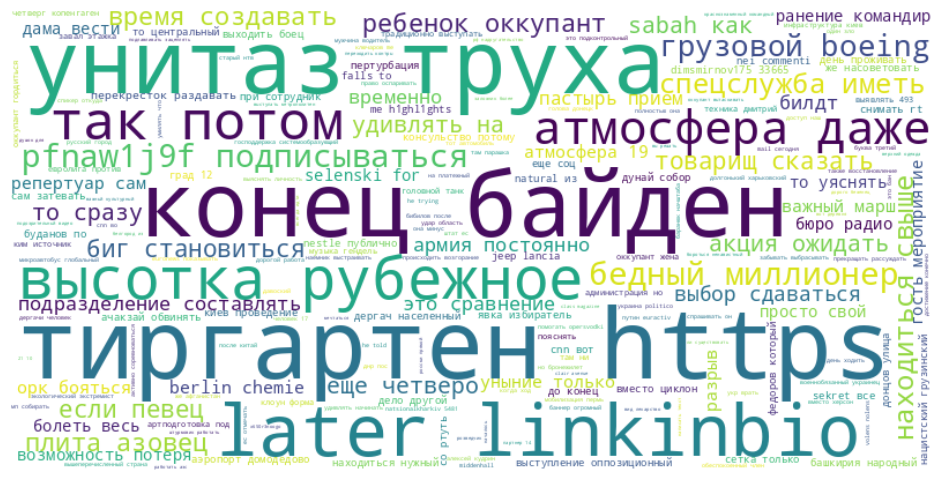

In [53]:
wordcloud=WordCloud(width=800,height=400,background_color='white',random_state=1)

wordcloud.generate_from_frequencies(coef_dict)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')
plt.show()


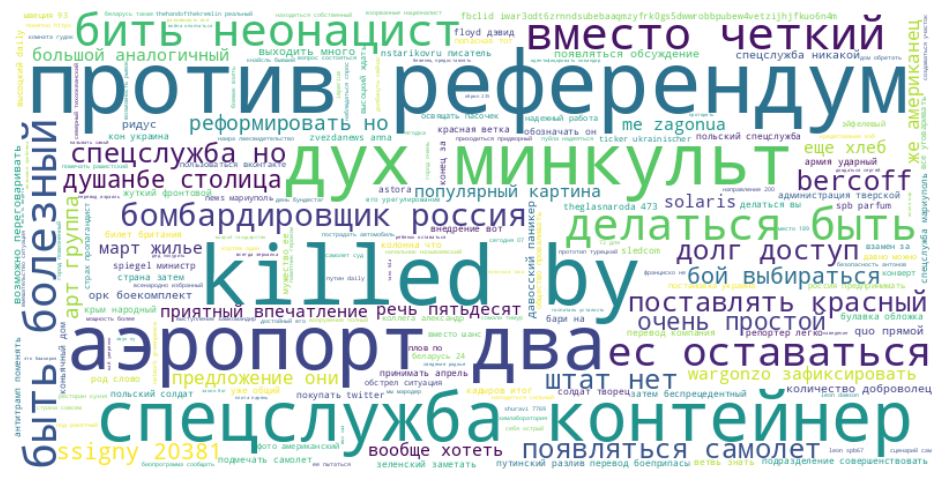

In [54]:
coef_list=list(zip(final_vocab,importance*-1))
coef_dict={x[0]: x[1] for x in coef_list}

wordcloud=WordCloud(width=800,height=400,background_color='white')

wordcloud.generate_from_frequencies(coef_dict)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')
plt.show()

# Errors 

In [60]:
drop_indices = [i for i in range(len(ukr_test.to_numpy())) if ukr_test.to_numpy()[i] == ukr_pred[i]]

In [61]:
ukr_test_miclassified = ukr_test.copy().reset_index().drop(drop_indices)['ukrainian']

In [79]:
data_indexes_misclassified = ukr_test.copy().reset_index().drop(drop_indices)['index'].to_numpy()

In [106]:
misclassified_data = data.iloc[data_indexes_misclassified,:]
misclassified_data[['msg','ukrainian']]

,msg,ukrainian
97264,екатеринбург . машинка в « сима - ленд » ...,0
111919,усиление на белорусский - украинский г...,0
99023,посол мельник призывать германия запре...,0
66405,""" путин отдавать приказ неофициально , ...",1
138268,официальный подтверждение https :// t . me...,0
...,...,...
28618,« единственный выход для путин – извин...,1
65063,"кто-то учиться в школа мышление "" апе...",1
24001,❗ ️жуткие кадр из буча . в один из...,1
57712,"телефон , украсть у один из жительниц...",1


In [113]:
preprocessed = preprocess(misclassified_data)

preprocess took 0.19 seconds.


In [114]:
lemmatized = lemmatize(preprocessed)

lemmatize took 16.13 seconds.


In [115]:
error_posts = lemmatized['msg'].to_numpy()

In [127]:
posts = [post.split(" ") for post in error_posts]
posts = [i for post in posts for i in post if len(i)>3]
text = " ".join(post for post in posts)

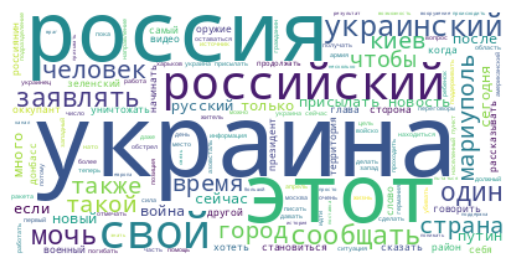

In [128]:
wordcloud = WordCloud(stopwords=CHEAT_WORDS+['и','d','не','на','с','который','у',
                                             'быть','как','весь','по','из','они','по',
                                             'в','за','что','наш','для','он','а','от','но','я','мы'], background_color="white").generate(text)


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()